# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# Сifar 10 dataset
This week, we shall focus on the image recognition problem on Cifar 10 dataset
* 50k images of shape 3x32x32
* 10 different classes (see examples)


In [0]:
import torchvision
import torch
from torchvision import transforms

# if you're running in colab, go to Runtime -> Change Runtimy Type -> GPU

In [0]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 50
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

## Image examples ##

<img src="https://i.ibb.co/1JZV1Rw/2019-10-26-13-47-29.png" alt="2019-10-26-13-47-29" border="0"></a>

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [0]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3072, 1064))
model.add_module('dense0_relu', nn.ReLU())
model.add_module('dense2', nn.Linear(1064, 512))
model.add_module('dropout0', nn.Dropout(0.05)) 
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense3', nn.Linear(512, 256))
model.add_module('dropout1', nn.Dropout(0.05))
model.add_module('dense2_relu', nn.ReLU())
model.add_module('dense4', nn.Linear(256, 64))
model.add_module('dropout2', nn.Dropout(0.05))
model.add_module('dense3_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 200)) # logits for 200 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

### Training on minibatches
* We got 50k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_dense = []
val_accuracy_dense = []

In [0]:
import numpy as np

opt = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 50 # total amount of full passes over training data

import time

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss_dense.append(loss.cpu().data.numpy())
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy_dense.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss_dense[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy_dense[-len(val_dataset) // batch_size :]) * 100))

Epoch 1 of 50 took 17.202s
  training loss (in-iteration): 	2.932337
  validation accuracy: 			10.08 %
Epoch 2 of 50 took 11.809s
  training loss (in-iteration): 	2.318467
  validation accuracy: 			16.00 %
Epoch 3 of 50 took 11.818s
  training loss (in-iteration): 	2.157540
  validation accuracy: 			18.65 %
Epoch 4 of 50 took 11.784s
  training loss (in-iteration): 	2.086789
  validation accuracy: 			22.91 %
Epoch 5 of 50 took 11.876s
  training loss (in-iteration): 	2.043582
  validation accuracy: 			23.24 %
Epoch 6 of 50 took 11.786s
  training loss (in-iteration): 	1.982003
  validation accuracy: 			28.05 %
Epoch 7 of 50 took 11.782s
  training loss (in-iteration): 	1.924198
  validation accuracy: 			31.56 %
Epoch 8 of 50 took 11.719s
  training loss (in-iteration): 	1.884079
  validation accuracy: 			32.36 %
Epoch 9 of 50 took 11.635s
  training loss (in-iteration): 	1.850280
  validation accuracy: 			33.05 %
Epoch 10 of 50 took 11.715s
  training loss (in-iteration): 	1.808998
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.

### Final test

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 128 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 1024 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3))
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('relu1', nn.ReLU())
model.add_module('conv2', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3))
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('relu2', nn.ReLU())
model.add_module('conv3', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3))
model.add_module('pool3', nn.MaxPool2d(2))
model.add_module('relu3', nn.ReLU())
model.add_module('flatten', Flatten())
model.add_module('dense0', nn.Linear(2048, 1024))
model.add_module('relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense1_logits', nn.Linear(1024, 10))

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_conv = []
val_accuracy_conv = []

In [0]:
from torchsummary import summary

summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 30, 30]           3,584
         MaxPool2d-2          [-1, 128, 15, 15]               0
              ReLU-3          [-1, 128, 15, 15]               0
            Conv2d-4          [-1, 256, 13, 13]         295,168
         MaxPool2d-5            [-1, 256, 6, 6]               0
              ReLU-6            [-1, 256, 6, 6]               0
            Conv2d-7            [-1, 512, 4, 4]       1,180,160
         MaxPool2d-8            [-1, 512, 2, 2]               0
              ReLU-9            [-1, 512, 2, 2]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
             ReLU-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                   

## retrain it ##

In [0]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration


for epoch in range(num_epochs):
    print (num_epochs)
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss_conv.append(loss.data.cpu().numpy())
    print (num_epochs)    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy_conv.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss_conv[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy_conv[-len(val_dataset) // batch_size :]) * 100))

100
100
100
Epoch 1 of 100 took 18.964s
  training loss (in-iteration): 	2.288642
  validation accuracy: 			19.68 %
100
100
100
Epoch 2 of 100 took 18.822s
  training loss (in-iteration): 	2.105922
  validation accuracy: 			24.93 %
100
100
100
Epoch 3 of 100 took 18.894s
  training loss (in-iteration): 	1.950737
  validation accuracy: 			30.71 %
100
100
100
Epoch 4 of 100 took 18.913s
  training loss (in-iteration): 	1.816284
  validation accuracy: 			33.90 %
100
100
100
Epoch 5 of 100 took 19.018s
  training loss (in-iteration): 	1.685271
  validation accuracy: 			40.65 %
100
100
100
Epoch 6 of 100 took 18.871s
  training loss (in-iteration): 	1.594859
  validation accuracy: 			41.27 %
100
100
100
Epoch 7 of 100 took 18.914s
  training loss (in-iteration): 	1.529277
  validation accuracy: 			45.10 %
100
100
100
Epoch 8 of 100 took 18.995s
  training loss (in-iteration): 	1.467734
  validation accuracy: 			46.39 %
100
100
100
Epoch 9 of 100 took 18.822s
  training loss (in-iteration): 

KeyboardInterrupt: ignored

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 20% validation accuracy at peak.

To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3))
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('bn1', nn.BatchNorm2d(128))
model.add_module('relu1', nn.ReLU())
model.add_module('conv2', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3))
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('bn2', nn.BatchNorm2d(256))
model.add_module('relu2', nn.ReLU())
model.add_module('conv3', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3))
model.add_module('pool3', nn.MaxPool2d(2))
model.add_module('bn3', nn.BatchNorm2d(512))
model.add_module('relu3', nn.ReLU())
model.add_module('flatten', Flatten())
model.add_module('dense0', nn.Linear(2048, 1024))
model.add_module('relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense1_logits', nn.Linear(1024, 10))

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_batchnorm = []
val_accuracy_batchnorm = []

In [0]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration


for epoch in range(num_epochs):
    print (num_epochs)
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss_batchnorm.append(loss.data.cpu().numpy())
    print (num_epochs)    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy_batchnorm.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss_batchnorm[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy_batchnorm[-len(val_dataset) // batch_size :]) * 100))

100
100
100
Epoch 1 of 100 took 19.844s
  training loss (in-iteration): 	1.450463
  validation accuracy: 			62.64 %
100
100
100
Epoch 2 of 100 took 19.681s
  training loss (in-iteration): 	1.003344
  validation accuracy: 			70.33 %
100
100
100
Epoch 3 of 100 took 19.625s
  training loss (in-iteration): 	0.794788
  validation accuracy: 			75.12 %
100
100
100
Epoch 4 of 100 took 19.646s
  training loss (in-iteration): 	0.636117
  validation accuracy: 			79.39 %
100
100
100
Epoch 5 of 100 took 19.604s
  training loss (in-iteration): 	0.504999
  validation accuracy: 			84.88 %
100
100
100
Epoch 6 of 100 took 19.643s
  training loss (in-iteration): 	0.379702
  validation accuracy: 			86.47 %
100
100
100
Epoch 7 of 100 took 19.685s
  training loss (in-iteration): 	0.268184
  validation accuracy: 			90.49 %
100
100
100
Epoch 8 of 100 took 19.744s
  training loss (in-iteration): 	0.180867
  validation accuracy: 			89.74 %
100
100
100
Epoch 9 of 100 took 19.616s
  training loss (in-iteration): 

KeyboardInterrupt: ignored


## Task 3: Data Augmentation

**Augmenti - A spell used to produce water from a wand (Harry Potter Wiki)**

<img src="https://github.com/yandexdataschool/Practical_DL/blob/spring2019/week03_convnets/HagridsHut_PM_B6C28_Hagrid_sHutFireHarryFang.jpg?raw=1" style="width:80%">

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)
* and casts to tensor

When testing, we don't need random crops, just normalize with same statistics.

In [0]:
import torchvision
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [0]:
augmented_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_augment)

Files already downloaded and verified


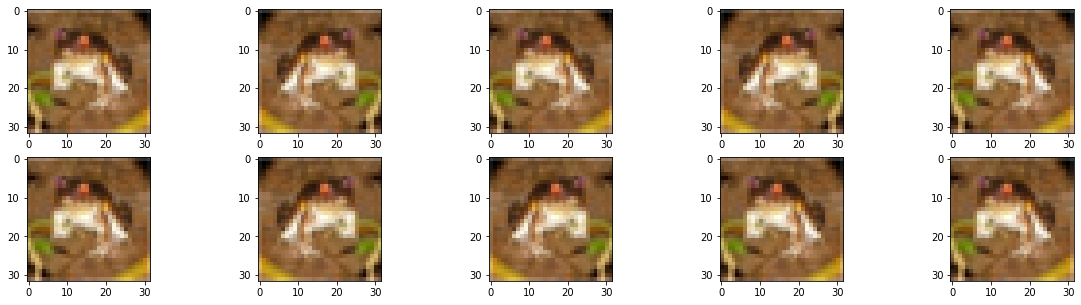

In [0]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
# Here we unnormalize data to make them look pretty
for i in range(10):
    plt.subplot(2, 5, i + 1)
    frog = augmented_dataset[0][0]
    unnormalized = frog.permute(1, 2, 0).numpy() * stds + means
    clipped = np.clip(unnormalized, 0, 1)
    plt.imshow(clipped)

You see?) Some of the frogs got flipped!

In [0]:
train_dataset, val_dataset = torch.utils.data.random_split(augmented_dataset, [40000, 10000])

# But we can not apply augmentations on validation dataset
from copy import deepcopy
val_dataset.dataset = deepcopy(val_dataset.dataset)
val_dataset.dataset.transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [0]:
batch_size = 50
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
# IMPORTANT: Reinitialize your model from the previous exercise

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3))
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('bn1', nn.BatchNorm2d(128))
model.add_module('relu1', nn.ReLU())
model.add_module('conv2', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3))
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('bn2', nn.BatchNorm2d(256))
model.add_module('relu2', nn.ReLU())
model.add_module('conv3', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3))
model.add_module('pool3', nn.MaxPool2d(2))
model.add_module('bn3', nn.BatchNorm2d(512))
model.add_module('relu3', nn.ReLU())
model.add_module('flatten', Flatten())
model.add_module('dense0', nn.Linear(2048, 1024))
model.add_module('relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense1_logits', nn.Linear(1024, 10))

opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_augmentation = []
val_accuracy_augmentation = []

In [0]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration


for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss_augmentation.append(loss.data.cpu().numpy())
    print (num_epochs)    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy_augmentation.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss_augmentation[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy_augmentation[-len(val_dataset) // batch_size :]) * 100))

100
100
Epoch 1 of 100 took 20.887s
  training loss (in-iteration): 	1.452166
  validation accuracy: 			58.80 %
100
100
Epoch 2 of 100 took 21.022s
  training loss (in-iteration): 	1.026113
  validation accuracy: 			66.74 %
100
100
Epoch 3 of 100 took 20.847s
  training loss (in-iteration): 	0.854680
  validation accuracy: 			71.24 %
100
100
Epoch 4 of 100 took 21.122s
  training loss (in-iteration): 	0.731224
  validation accuracy: 			72.96 %
100
100
Epoch 5 of 100 took 20.956s
  training loss (in-iteration): 	0.646118
  validation accuracy: 			73.40 %
100
100
Epoch 6 of 100 took 20.938s
  training loss (in-iteration): 	0.569831
  validation accuracy: 			75.96 %
100
100
Epoch 7 of 100 took 21.024s
  training loss (in-iteration): 	0.498521
  validation accuracy: 			76.70 %
100
100
Epoch 8 of 100 took 20.967s
  training loss (in-iteration): 	0.437715
  validation accuracy: 			76.80 %
100
100
Epoch 9 of 100 took 20.943s
  training loss (in-iteration): 	0.379712
  validation accuracy: 			

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f88b53f5be0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


100
Epoch 41 of 100 took 21.198s
  training loss (in-iteration): 	0.003596
  validation accuracy: 			81.16 %
100
100
Epoch 42 of 100 took 20.778s
  training loss (in-iteration): 	0.003998
  validation accuracy: 			81.18 %
100
100
Epoch 43 of 100 took 20.881s
  training loss (in-iteration): 	0.003905
  validation accuracy: 			81.17 %
100
100
Epoch 44 of 100 took 21.051s
  training loss (in-iteration): 	0.003494
  validation accuracy: 			81.20 %
100
100
Epoch 45 of 100 took 20.966s
  training loss (in-iteration): 	0.002920
  validation accuracy: 			81.60 %
100
100
Epoch 46 of 100 took 20.961s
  training loss (in-iteration): 	0.002718
  validation accuracy: 			81.45 %
100
100
Epoch 47 of 100 took 21.000s
  training loss (in-iteration): 	0.002571
  validation accuracy: 			81.42 %
100
100
Epoch 48 of 100 took 21.012s
  training loss (in-iteration): 	0.002608
  validation accuracy: 			81.44 %
100
100
Epoch 49 of 100 took 20.863s
  training loss (in-iteration): 	0.002546
  validation accuracy

We need for test data __only normalization__, not cropping and rotation

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_dataset = <YOUR CODE>
test_batch_gen = <YOUR CODE>

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

In [0]:
# Analyze your model here

Feel free to play with the model to get better score :)